<a href="https://colab.research.google.com/github/theaayushraman/StockPricePrediction/blob/main/LSTM_StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Neural Network for Stock Price Prediction**

A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. They are distinguished by their “memory” as they take information from prior inputs to influence the current input and output. While traditional deep neural networks assume that inputs and outputs are independent of each other, the output of recurrent neural networks depend on the prior elements within the sequence.

When we observe stock price-volume data, it is also a form of sequential/time series data. It is more than likely that the stock price on a given day will be influenced by the trends/patterns seen in the price on the preceding days. One can take advantage of deep learning techniques like RNNs to learn these patterns/trends in the data and make predictions on the stock price.

LSTM (Long Short-Term Memory) is a type of RNN architecture which allows information to persist and can identify long-term dependencies. This type of network may be better suited for forecasting time series data such as stock prices as it can learn relatively long-term trends in the data and produce more accurate predictions on the future prices.

## **Dataset**

In [15]:
!pip install yfinance
!pip install pandas-ta

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")

We will be using stock-price data over a duration of 10 years as markets are cyclical in nature and usually repeat their behaviour every 10 years

In [17]:
start_date = "2013-12-31"
end_date = "2023-12-31"

In [18]:
data = {}

ticker = yf.Ticker("AAPL")

data['High'] = ticker.history(start = start_date, end = end_date)['High']
data['Low'] = ticker.history(start = start_date, end = end_date)['Low']
data['Close'] = ticker.history(start = start_date, end = end_date)['Close']
data['Volume'] = ticker.history(start = start_date, end = end_date)['Volume']

data = pd.DataFrame(data)

data.head()

,High,Low,Close,Volume
Date,,,,
2013-12-31 00:00:00-05:00,17.573909,17.345969,17.565769,223084400
2014-01-02 00:00:00-05:00,17.440842,17.283977,17.318731,234684800
2014-01-03 00:00:00-05:00,17.336580,16.921091,16.938313,392467600
2014-01-06 00:00:00-05:00,17.120536,16.707239,17.030676,412610800
2014-01-07 00:00:00-05:00,17.094233,16.842498,16.908876,317209200


## **Technical Indicators**

Technical indicators are heuristic or pattern-based signals produced by the price, volume, and/or open interest of a security. Technical indicators can be used to predict future price movements of a security and identify possible trends. These indicators can broadly be categorised into two types:

> **Lagging Indicators**
>> These indicators provide delayed feedback i.e they give a signal once the price movement has already passed or is in progress. Lagging indicators can be used to confirm a price trend which has already initiated.

> **Leading Indicators**
>> These indicators are used to predict the future direction of a price movement. Leading indicators are used to identify potential trends in the future and enter the market accordingly.



For the purpose of this model, a combination of both leading as well as lagging technical indicators will be fed into the network in order to follow price trends once they are in place as well as predict future trends and forecast the price accurately.

### **1) Relative Strength Index (RSI)**
RSI is a momentum indicator which measures the speed and magnitude of a security's recent price changes. It is used to evaluate overpriced or underpriced conditions of a stock price and can predict possible trend reversals in the future. It is an oscillator which ranges between 0 and 100.

Traditionally,
- RSI >= 70 : indicates overbought condition, possible price drop in the future (sell signal)
- RSI <= 30 : indicates oversold conditition, possible price increase in the future (buy signal)

Image source : Investopedia

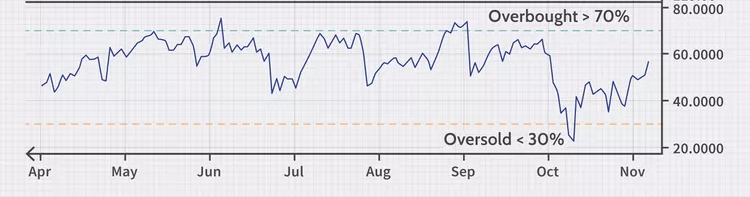

### **2) Williams %R (WPR)**
WPR is also a momentum indicator which is used to measure overbought and oversold levels of a stock price. It takes a different approach than the RSI and compares a stock's closing price to the high-low range over a specified lookback period. This is also an oscillator, and values range between -100 and 0.

Traditionally,
- WPR >= -20 : indicates overbought condition, possible price drop in the future (sell signal)
- WPR <= -80 : indicates oversold conditition, possible price increase in the future (buy signal)

Image source : Investopedia

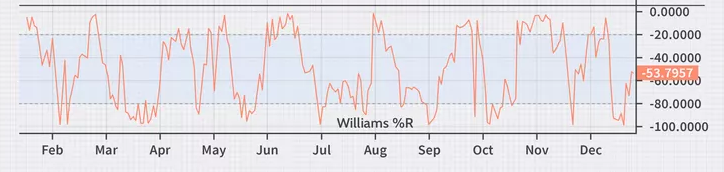

### **3) Volume Weighted Average Price (VWAP)**
VWAP is a type of moving-average indicator which incorporates both stock price as well as volume data. It can be used to observe the trend which the stock price might be currently following. VWAP can prove to be a better alternative to typical moving averages as it gives more significance to the price levels at which there is greater volume of trade.

Image source : ForexBee

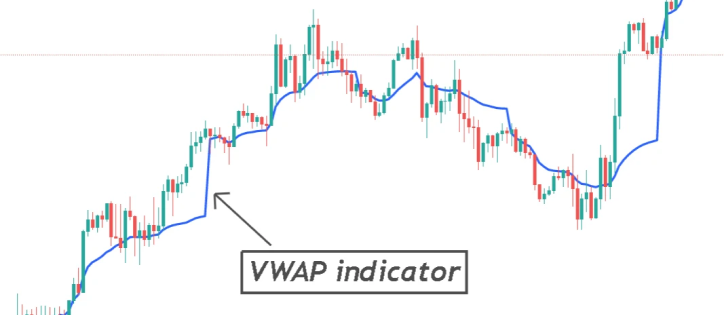

### **4) Moving Average Convergence-Divergence (MACD)**
MACD is a trend-following momentum indicator which shows the relationship between two exponential moving averages (EMAs) of a stock's price. It is typically calculated by subtracting the 26-period EMA from the 12-period EMA.
Positive/negative values of the MACD are used to identify uptrends/downtrends. When there is a rapid rise/fall in the MACD level, it usually indicates overbought/oversold levels and can result in possible price corrections.

Image source : StockGoodies

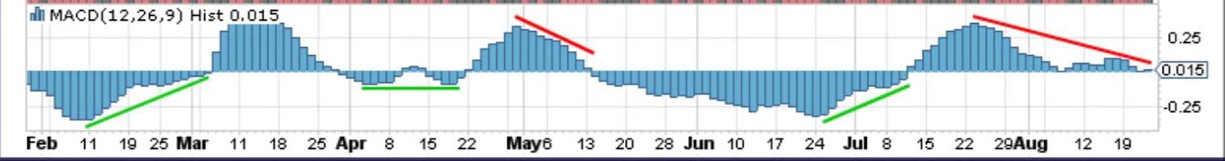

In [19]:
import pandas_ta as ta

In [20]:
data['RSI'] = ta.rsi(data.Close, length = 14)
data['WPR'] = ta.willr(data.High, data.Low, data.Close, length = 14)
data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume, length = 14)
data['MACD'] = ta.ema(data.Close, length = 12) - ta.ema(data.Close, length = 26)

<ipython-input-20-fa74dfd1ce99>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume, length = 14)
<ipython-input-20-fa74dfd1ce99>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume, length = 14)


#### Creating buy/sell trading signals using the indicator data to feed into the network for predicting the future stock price movement:

In [21]:
rsi_signal = []
for rsi in data['RSI']:
  if rsi > 70:
    rsi_signal.append(-1)
  elif rsi < 30:
    rsi_signal.append(1)
  else:
    rsi_signal.append(0)

data['RSI_signal'] = rsi_signal

wpr_signal = []
for wpr in data['WPR']:
  if wpr > -20:
    wpr_signal.append(-1)
  elif wpr < -80:
    wpr_signal.append(1)
  else:
    wpr_signal.append(0)

data['WPR_signal'] = wpr_signal

## **Target Variable**

For the purpose of this model, we will be predicting the next day stock price on the basis of data fed in from the previous 14 days. The target variable will be defined as the "Close" stock price for the next day.

In [22]:
data['TargetNextClose'] = data['Close'].shift(-1)
data.dropna(inplace = True)
data.reset_index(inplace = True)

data.head()

,Date,High,Low,Close,Volume,RSI,WPR,VWAP,MACD,RSI_signal,WPR_signal,TargetNextClose
0,2014-02-06 00:00:00-05:00,16.174142,15.994917,16.142958,257765200,39.754284,-65.440863,16.104005,-0.498403,0,0,16.368795
1,2014-02-07 00:00:00-05:00,16.471164,16.296351,16.368795,370280400,45.004118,-54.124760,16.378770,-0.449902,0,0,16.662041
2,2014-02-10 00:00:00-05:00,16.756535,16.315880,16.662041,345559200,50.977670,-39.431049,16.578152,-0.383383,0,0,16.881580
3,2014-02-11 00:00:00-05:00,16.937960,16.678102,16.881580,282256800,54.925011,-27.532550,16.832547,-0.309385,0,0,16.880314
4,2014-02-12 00:00:00-05:00,16.994967,16.795901,16.880314,308100800,54.897549,-26.570290,16.890394,-0.247985,0,0,17.148369


In [23]:
date_range = data['Date']

In [24]:
data_set = data.iloc[:, 1:12]
data_set.drop(['RSI'], axis = 1, inplace = True)
data_set.drop(['WPR'], axis = 1, inplace = True)
data_set.drop(['High'], axis = 1, inplace = True)
data_set.drop(['Low'], axis = 1, inplace = True)

pd.set_option('display.max_columns', None)

data_set.head()

,Close,Volume,VWAP,MACD,RSI_signal,WPR_signal,TargetNextClose
0,16.142958,257765200,16.104005,-0.498403,0,0,16.368795
1,16.368795,370280400,16.378770,-0.449902,0,0,16.662041
2,16.662041,345559200,16.578152,-0.383383,0,0,16.881580
3,16.881580,282256800,16.832547,-0.309385,0,0,16.880314
4,16.880314,308100800,16.890394,-0.247985,0,0,17.148369


## **Feature Scaling**

Since the model will be using a variety of data having different magnitude and scale, all the input variables will be normalised into a range of 0 to 1.
This will assist the deep learning model during training as the gradient descent step will be faster. It will also help ensure that the training process does not fail due to problems such as exploding gradient.

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler_feature_train = MinMaxScaler(feature_range = (0, 1))
scaler_feature_test = MinMaxScaler(feature_range = (0, 1))
scaler_target_train = MinMaxScaler(feature_range = (0, 1))
scaler_target_test = MinMaxScaler(feature_range = (0, 1))

feature_set = data_set.drop(['TargetNextClose'], axis = 1)

target_set = np.array(data_set['TargetNextClose']).reshape(-1, 1)


In [26]:
splitlimit = int(len(feature_set) * 0.8)

feature_set_train, feature_set_test = feature_set[:splitlimit], feature_set[splitlimit:]
feature_set_train_scaled = scaler_feature_train.fit_transform(feature_set_train)
feature_set_test_scaled = scaler_feature_test.fit_transform(feature_set_test)

target_set_train, target_set_test = target_set[:splitlimit], target_set[splitlimit:]
target_set_train_scaled = scaler_target_train.fit_transform(target_set_train)
target_set_test_scaled = scaler_target_test.fit_transform(target_set_test)

## **Constructing the dataset**

Input data to the network will be a series of dataframes having the feature data over a lookback period of 14 days. The lookback window will roll over the entire data time period and will be used to predict the Close price of the next day.

In [27]:
X_train = []

backcandles = 14
features = 6

for i in range(features):
    X_train.append([])

    for j in range(backcandles, feature_set_train_scaled.shape[0]):
        X_train[i].append(feature_set_train_scaled[j-backcandles: j, i])

X_train = np.moveaxis(X_train, [0], [2])

X_test = []

for i in range(features):
    X_test.append([])

    for j in range(backcandles, feature_set_test_scaled.shape[0]):
        X_test[i].append(feature_set_test_scaled[j-backcandles: j, i])

X_test = np.moveaxis(X_test, [0], [2])

X_train, X_test = np.array(X_train), np.array(X_test)
Yi, Yj = np.array(target_set_train_scaled[backcandles:]), np.array(target_set_test_scaled[backcandles:]),
Y_train, Y_test = np.reshape(Yi, (len(Yi), 1)), np.reshape(Yj, (len(Yj), 1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1978, 14, 6)
(485, 14, 6)
(1978, 1)
(485, 1)


## **Building and training the LSTM neural network**

In [14]:
import tensorflow as tf
import keras

lstm_input = keras.layers.Input(shape = (backcandles, features), name = 'lstm_input')
lstm1 = keras.layers.LSTM(100, return_sequences = True, name = 'firstLSTM_layer')(lstm_input)
lstm2 = keras.layers.LSTM(75, name = 'secondLSTM_layer')(lstm1)
dense = keras.layers.Dense(1, name = 'dense_layer')(lstm2)
out = keras.layers.Activation('linear', name = 'output')(dense)

model = keras.models.Model(inputs = lstm_input, outputs = out)
adam = keras.optimizers.Adam()

model.compile(optimizer = adam, loss = 'mse', metrics=[tf.keras.metrics.Accuracy()])
model.fit(x = X_train, y = Y_train, batch_size = 15, epochs = 20, shuffle = True)

Epoch 1/20
132/132 [==============================] - 6s 19ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 2/20
132/132 [==============================] - 3s 24ms/step - loss: 3.0600e-04 - accuracy: 0.0000e+00
Epoch 3/20
132/132 [==============================] - 2s 15ms/step - loss: 2.9096e-04 - accuracy: 0.0000e+00
Epoch 4/20
132/132 [==============================] - 2s 16ms/step - loss: 4.0010e-04 - accuracy: 0.0000e+00
Epoch 5/20
132/132 [==============================] - 2s 16ms/step - loss: 2.9777e-04 - accuracy: 0.0000e+00
Epoch 6/20
132/132 [==============================] - 2s 16ms/step - loss: 2.9333e-04 - accuracy: 0.0000e+00
Epoch 7/20
132/132 [==============================] - 3s 20ms/step - loss: 2.6646e-04 - accuracy: 0.0000e+00
Epoch 8/20
132/132 [==============================] - 3s 24ms/step - loss: 2.8661e-04 - accuracy: 0.0000e+00
Epoch 9/20
132/132 [==============================] - 2s 17ms/step - loss: 3.2679e-04 - accuracy: 0.0000e+00
Epoch 10/20
132/132 [==

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 14, 6)]           0         
                                                                 
 firstLSTM_layer (LSTM)      (None, 14, 100)           42800     
                                                                 
 secondLSTM_layer (LSTM)     (None, 75)                52800     
                                                                 
 dense_layer (Dense)         (None, 1)                 76        
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 95676 (373.73 KB)
Trainable params: 95676 (373.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Test Data Predictions**

In [29]:
Y_pred = model.predict(X_test)

16/16 [==============================] - 2s 13ms/step


In [30]:
Y_test_prices = pd.DataFrame(scaler_target_test.inverse_transform(Y_test), index = date_range[len(date_range)-Y_test.shape[0]:])
Y_pred_prices = pd.DataFrame(scaler_target_test.inverse_transform(Y_pred), index = date_range[len(date_range)-Y_test.shape[0]:])

### **Predicted price vs Actual price**



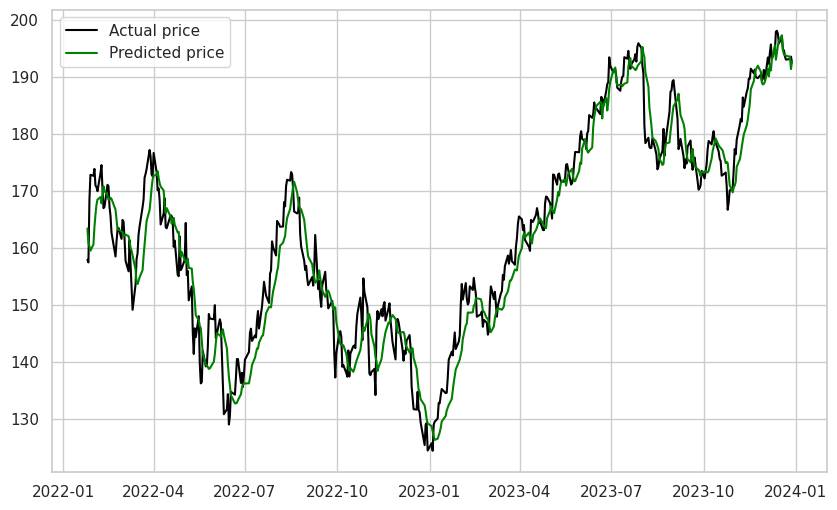

In [31]:
plt.figure(figsize = (10, 6))
plt.plot(Y_test_prices, color = 'black', label = 'Actual price')
plt.plot(Y_pred_prices, color = 'green', label = 'Predicted price')
plt.legend()
plt.show()

## **Evaluation Metrics**

Following evaluation metrics are used to analyse the performance of the model:


*   Correlation
*   Cointegration test
*   Root mean square error (RMSE)





### **1) Correlation**

In [32]:
print("Correlation between actual time series and predicted time series:")
np.round(np.corrcoef(Y_test_prices[0], Y_pred_prices[0])[0,1], 3)

Correlation between actual time series and predicted time series:


0.966

### **2) Cointegration Test**

In [33]:
import statsmodels.tsa.stattools as ts

coint_result = ts.coint(Y_test_prices[0], Y_pred_prices[0])
p_val = coint_result[1]

print("P-Value for the cointegration test:")
print(np.round(p_val, 10))

P-Value for the cointegration test:
1.1e-09


The cointegration test results in a P-value which is practically 0. This indicates that the time series of the predicted prices and the actual prices are highly cointegration i.e they show a strong positive correlation over their duration

### **3) Root Mean Square Error (RMSE)**
Expressed as a percentage


In [34]:
rmse = np.round(np.sqrt(np.mean(((Y_test_prices[0] - Y_pred_prices[0])/Y_test_prices[0])**2)), 3)
print("Root Mean Square Error (RMSE) =", np.round(rmse*100, 3), "%")

Root Mean Square Error (RMSE) = 3.1 %
